<a href="https://colab.research.google.com/github/xpurwar/CV-Green-Screen-Processor-/blob/main/bg_remover.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt


def load_img(impath):
    """
    Loads an image from a specified location and returns it in RGB format.
    Input:
    - impath: a string specifying the target image location.
    Returns an RGB image.
    """
    img = cv2.imread(impath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def minbbox(mask):
    """
    Takes in a binary mask and returns a minimal bounding box around
    the non-zero elements.
    Input:
    - mask: a mask image (should contain only 0 and non-zero elements)
    Returns:
    - bbox: a list of four points in the form: [min_x, min_y, max_x, max_y]
    """

    min_h = np.where(mask > 0)[0].min()
    max_h = np.where(mask > 0)[0].max()
    min_w = np.where(mask > 0)[1].min()
    max_w = np.where(mask > 0)[1].max()

    return [min_w, min_h, max_w, max_h]

def pad_to_size(elimg, mask, scene, location):
    """
    Adds padding around element image and mask so that the element is
    centered in location corresponding to target in scene.
    Input:
    - elimg: The element image (assume it is three channels,
        but no restrictions on float or int)
    - mask: A mask corresponding to elimg
    - scene: The scene to insert into
    - location: The location the element will be inserted (relative to the center of the element)
    Returns:
    - big_img: a version of the element image padded out to the same dimensions as the scene
    - big_mask: a version of the element mask padded out to the same dimensions as the scene
    """
    [elh, elw, c] = elimg.shape

    big_img = np.zeros(scene.shape, dtype=float)
    big_mask = np.zeros((scene.shape[0], scene.shape[1]))

    skip_top = 0
    if int(location[1] - elh / 2) < 0:
        skip_top = abs(int(location[1] - elh / 2))

    skip_bot = 0
    if int(location[1] + elh / 2) > scene.shape[0]:
        skip_bot = int(location[1] + elh / 2) - scene.shape[0]

    skip_left = 0
    if int(location[0] - elw / 2) < 0:
        skip_left = abs(int(location[0] - elw / 2))

    skip_right = 0
    if int(location[0] + elw / 2) > scene.shape[1]:
        skip_right = int(location[0] + elw / 2) - scene.shape[1]

    targ_h_min = max(int(location[1] - elh / 2), 0)
    targ_h_max = min(int(location[1] + elh / 2), scene.shape[0])
    targ_w_min = max(int(location[0] - elw / 2), 0)
    targ_w_max = min(int(location[0] + elw / 2), scene.shape[1])

    # Due to rounding errors, this is sometimes off by one, so we do a last check
    # of the skip_top and skip_left variables, adjusting as needed
    if targ_h_max - targ_h_min < elh-skip_bot - skip_top:
        skip_top+=1
    if targ_w_max - targ_w_min < elw - skip_right - skip_left:
        skip_left+=1

    big_img[targ_h_min:targ_h_max, targ_w_min:targ_w_max, :] = elimg[skip_top:elh-skip_bot, skip_left:elw-skip_right, :]
    big_mask[targ_h_min:targ_h_max, targ_w_min:targ_w_max] = mask[skip_top:elh-skip_bot, skip_left:elw-skip_right]

    return big_img, big_mask



def green_extract(impath):
    """
    Loads an image from a specified location and performs green screen extraction.
    Input:
    - impath: a string specifying the target image location.
    Returns:
    - elements: a list of RGB images containing minimally bounded objects.
    - masks: a list of binary masks (numpy 'int' type) corresponding to the elements above
    """
    if ("francine_poppins" in impath):
      print("francine_poppins")
      thresh = 120
      fact = 1.5
    elif ("head" in impath):
      print("head")
      thresh = 100
      fact = 1.5
    elif ("ball_toss" in impath):
      print("Ball_toss")
      thresh = 140
      fact = 1.5
    else:
      thresh = 50
      fact = 1.5

    elements = []
    masks = []
    img = cv2.imread(impath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    (h,w,c) = img.shape

    gs_mask = np.zeros((h,w), dtype=bool)
    gs_mask = img[:,:,1] < fact*img[:,:,0]
    gs_mask = np.logical_or(gs_mask, img[:,:,1] < fact*img[:,:,2])
    gs_mask = np.logical_or(gs_mask, img[:,:,1] < thresh)
    gsfinal_mask = gs_mask.astype('uint8')

    (_, labels, stats, centroids) = cv2.connectedComponentsWithStats(gs_mask.astype('uint8'))
    idxs = stats[:,4].argsort()
    min_pixel_thresh = 1000
    impblobs = 0
    for idx in idxs:
        if stats[:,4][idx]>min_pixel_thresh:
            impblobs += 1
    keepids = idxs[-impblobs:]
    labels[labels!=keepids[0]] = 0
    if ("calden_falling.png" in impath or "head.png" in impath):
      morph_size = 9
      morph_kern = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (morph_size,morph_size))
      erode_mask = cv2.erode(gs_mask.astype(np.uint8), morph_kern, iterations=2)
      open_mask = cv2.dilate(erode_mask, morph_kern, iterations=1)
      left, top, right, bottom = minbbox(open_mask)
      bounding_box_img = img[top:bottom, left:right]
      bounding_box_mask = open_mask[top:bottom, left:right]
      final_mask = cv2.cvtColor(bounding_box_mask.astype('uint8'), cv2.COLOR_GRAY2RGB)
      left, top, right, bottom = minbbox(final_mask)
      bbox_img = img[top:bottom, left:right, :] / 255
      bbox_mask = gsfinal_mask[top:bottom, left:right]
      location = [centroids[0][0], centroids[0][1]]
      padded_element, padded_mask = pad_to_size(bbox_img, bbox_mask, img, location)
      elements.append(padded_element)
      masks.append(padded_mask)
    if impblobs == 2: # one element
        for e in keepids[1:]:
            left, top, right, bottom = minbbox(gsfinal_mask)
            bbox_img = img[top:bottom, left:right, :] / 255
            bbox_mask = gsfinal_mask[top:bottom, left:right]
            location = [centroids[0][0], centroids[0][1]]
            padded_element, padded_mask = pad_to_size(bbox_img, bbox_mask, img, location)
            elements.append(padded_element)
            masks.append(padded_mask)

    else: # more than one elements
        morph_size = 9
        morph_kern = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (morph_size,morph_size))
        erode_mask = cv2.erode(gs_mask.astype(np.uint8), morph_kern, iterations=1)
        final_mask = cv2.dilate(erode_mask, morph_kern, iterations=1)
        left, top, right, bottom = minbbox(final_mask)
        (_, labels, stats, centroids) = cv2.connectedComponentsWithStats(gs_mask.astype('uint8'))
        for idx in idxs:
            if stats[:,4][idx]>min_pixel_thresh:
                impblobs += 1
        keepids = idxs[-impblobs:]
        labels[labels!=keepids[0]] = 0
        contours, _ = cv2.findContours(final_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for contour in contours:
            mask = np.zeros_like(final_mask, dtype=np.uint8)
            cv2.drawContours(mask, [contour],-1, color=1, thickness = cv2.FILLED)
            minx, miny, maxx, maxy = minbbox(mask)
            bbox_img = img[miny:maxy, minx:maxx, :] / 255
            bbox_mask = mask[miny:maxy, minx:maxx]
            location = [centroids[0][0], centroids[0][1]]
            padded_element, padded_mask = pad_to_size(bbox_img, bbox_mask, img, location)
            elements.append(padded_element)
            masks.append(padded_mask)
    return elements, masks


head
ummmm tf


(-0.5, 717.5, 920.5, -0.5)

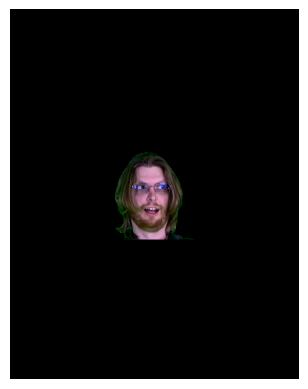

In [ ]:
elements, masks = green_extract('/content/drive/MyDrive/Computer Vision/imgs_A3/test_imgs/head.png')
# return as a list - connected components
plt.imshow(elements[1]*masks[1][:,:,None])
plt.axis('off')

In [ ]:
! pip install imutils

In [ ]:
import cv2
import numpy as np
import imutils

def affine_insert(scene, element, elmask, eldepth, location, height,
                  angle=0, scene_depth=None, alpha=1):
    """
    Inserts an element into a scene according to various parameterized controls.

    Parameters:
    - scene: RGB image into which the element should be inserted.
    - element: RGB image of the element to be inserted.
    - elmask: Binary mask corresponding to the element.
    - eldepth: Scalar value specifying the depth of the element.
    - location: Tuple (x, y) specifying the normalized centroid location.
    - height: Normalized height of the element's bounding box.
    - angle: Clockwise rotational angle for the element.
    - scene_depth: Depth map providing depth values for all points in the scene.
    - alpha: Transparency value (1 is fully opaque).

    Returns:
    - out_scene: Composite scene with the inserted element.
    - out_depth: Updated depth map for the scene.
    """
    scene_copy = np.copy(scene)

    if scene_depth is None:
        scene_depth = np.full((scene.shape[0], scene.shape[1]), np.inf)  # Make background infinitely far away
    out_depth = np.copy(scene_depth)
    out_scene = np.copy(scene)

    h_bkg, w_bkg, _ = scene.shape
    h_e, w_e, _ = element.shape

    fy = int(height * h_bkg)
    fx = int((fy * w_e) / h_e)
    points = (fx, fy)
    resized_element = cv2.resize(element, points, interpolation=cv2.INTER_LINEAR).astype("float32") * 255
    resized_mask = cv2.resize(elmask, points, interpolation=cv2.INTER_LINEAR).astype("float32")

    rotated_element = imutils.rotate_bound(resized_element, angle)
    rotated_mask = imutils.rotate_bound(resized_mask, angle)

    h_rot, w_rot, _ = rotated_element.shape

    # Calculate insertion coordinates
    insert_x = int(location[0] * w_bkg - w_rot / 2)
    insert_y = int(location[1] * h_bkg - h_rot / 2)
    insert_x = max(0, min(insert_x, w_bkg -w_rot))
    insert_y = max(0, min(insert_y, h_bkg - h_rot))

    for i in range(h_rot):
        for j in range(w_rot):
            if rotated_mask[i, j] > 0:
                if insert_y + i >= h_bkg or insert_x + j >= w_bkg:
                    continue
                pixel_depth = scene_depth[insert_y+i, insert_x + j]
                if eldepth < pixel_depth:
                    for k in range(3):
                        out_scene[insert_y + i, insert_x + j, k] = (alpha * rotated_element[i, j, k] +(1 - alpha) * scene[insert_y + i, insert_x + j, k])
                    out_depth[insert_y +i, insert_x +j] = eldepth

    return out_scene, out_depth


In [ ]:
from scipy.io import loadmat

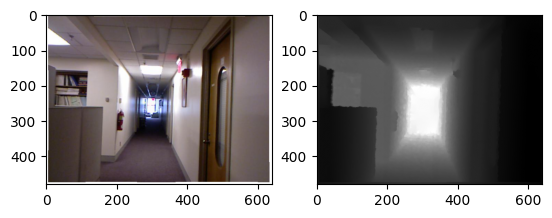

In [ ]:
bgname = '_15'
d = loadmat('/content/drive/MyDrive/Computer Vision/imgs_A3/depth_maps/depth' + bgname + '.mat')
depth_map = d['dimg']
bckgrd = load_img('/content/drive/MyDrive/Computer Vision/imgs_A3/backgrounds/image' + bgname + '.png')
plt.subplot(1,2,1)
plt.imshow(bckgrd)
plt.subplot(1,2,2)
plt.imshow(depth_map, cmap='gray')

head


(-0.5, 639.5, 479.5, -0.5)

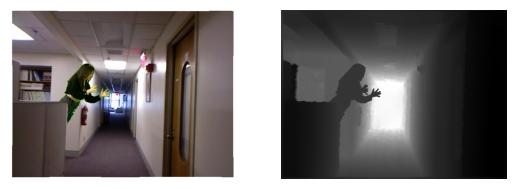

In [ ]:
elements, masks = green_extract('/content/drive/MyDrive/Computer Vision/imgs_A3/custom_imgs/megan_horflip.png')

megan = elements[0]
megan_mask = masks[0]

elements, masks = green_extract('/content/drive/MyDrive/Computer Vision/imgs_A3/test_imgs/head.png')

head = elements[1]
head_mask = masks[1]

scene, scene_depth = affine_insert(bckgrd, megan, megan_mask, 3.0, [0.2,0.7], 0.7, 35, depth_map)

plt.subplot(1,2,1)
plt.imshow(scene)
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(scene_depth, cmap='gray')
plt.axis('off')

(-0.5, 639.5, 479.5, -0.5)

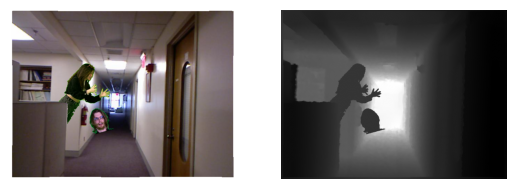

In [ ]:
scene2, scene_depth2 = affine_insert(scene, head, head_mask, 2.9, [0.4,0.68], 0.6, -15, scene_depth)

plt.subplot(1,2,1)
plt.imshow(scene2)
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(scene_depth2, cmap='gray')
plt.axis('off')

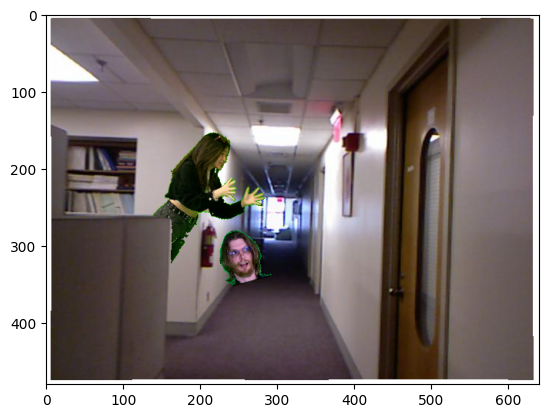

In [ ]:
plt.imshow(scene2)

head


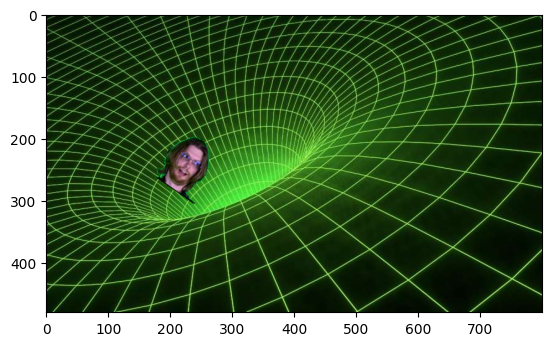

In [ ]:

def custom_compose():
    """
    This is a functionalized script for performing image composition using the
    tools developed in this assignment. Note that you are free to hardcode things
    here; this only needs to return one image.
    Returns:
    - out_scene: a composite scene.
    """
    bckgrd = load_img('/content/drive/MyDrive/Computer Vision/imgs_A3/custom_imgs/Wormhole.jpg')

    elements, masks = green_extract('/content/drive/MyDrive/Computer Vision/imgs_A3/test_imgs/head.png')

    head = elements[1]
    head_mask = masks[1]

    out_scene, scene_depth = affine_insert(bckgrd, head, head_mask, 3.0, [0.1,0.8], 0.8, 35)

    plt.imshow(out_scene)
custom_compose()
